In [633]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [634]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets import CRSPMonthly
import seaborn as sns
import matplotlib.pyplot as plt

In [635]:
# Load dataset
df = (
    CRSPMonthly(start_date=date(2006, 1, 1), end_date=date(2024, 8, 1))
    .load_all()
    .select(["permno", "ticker", "date", "shrout", "prc", "ret"])
)

df

permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10001,"""EWST""",2006-01-31,2930.0,9.49,-0.016495
10001,"""EWST""",2006-02-28,2931.0,9.39,-0.010537
10001,"""EWST""",2006-03-31,2932.0,10.99,0.170394
10001,"""EWST""",2006-04-28,2932.0,9.95,-0.094632
10001,"""EWST""",2006-05-31,2932.0,9.766,-0.010452
…,…,…,…,…,…
93436,"""TSLA""",2024-03-28,3.188966e6,175.78999,-0.129235
93436,"""TSLA""",2024-04-30,3.189196e6,183.28,0.042608
93436,"""TSLA""",2024-05-31,3.189196e6,178.08,-0.028372


In [636]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-12 to t-2 (lagged)
df = df.with_columns(
    pl.col("logret")
    .rolling_sum(window_size=11, min_periods=11)
    .shift(1)
    .over("permno")
    .alias("mom")
)

df

permno,ticker,date,shrout,prc,ret,logret,mom
i64,str,date,f64,f64,f64,f64,f64
10001,"""EWST""",2006-01-31,2930.0,9.49,-0.016495,-0.016633,null
10001,"""EWST""",2006-02-28,2931.0,9.39,-0.010537,-0.010593,null
10001,"""EWST""",2006-03-31,2932.0,10.99,0.170394,0.15734,null
10001,"""EWST""",2006-04-28,2932.0,9.95,-0.094632,-0.099414,null
10001,"""EWST""",2006-05-31,2932.0,9.766,-0.010452,-0.010507,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-03-28,3.188966e6,175.78999,-0.129235,-0.138383,-0.027264
93436,"""TSLA""",2024-04-30,3.189196e6,183.28,0.042608,0.041725,0.067537
93436,"""TSLA""",2024-05-31,3.189196e6,178.08,-0.028372,-0.028782,-0.10676


In [637]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10001,"""EWST""",2006-12-29,2959.0,11.1,-0.037294,-0.038007,0.205156,11.53
10001,"""EWST""",2007-01-31,2959.0,11.3584,0.023279,0.023012,0.183782,11.1
10001,"""EWST""",2007-02-28,2989.0,14.19,0.261621,0.232397,0.217387,11.3584
10001,"""EWST""",2007-03-30,3002.0,14.47,0.019732,0.01954,0.292444,14.19
10001,"""EWST""",2007-04-30,3002.0,14.51,0.002764,0.00276,0.411397,14.47
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-03-28,3.188966e6,175.78999,-0.129235,-0.138383,-0.027264,201.88
93436,"""TSLA""",2024-04-30,3.189196e6,183.28,0.042608,0.041725,0.067537,175.78999
93436,"""TSLA""",2024-05-31,3.189196e6,178.08,-0.028372,-0.028782,-0.10676,183.28


In [638]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10001,"""EWST""",2006-12-29,2959.0,11.1,-0.037294,-0.038007,0.205156,11.53,"""6"""
10001,"""EWST""",2007-01-31,2959.0,11.3584,0.023279,0.023012,0.183782,11.1,"""6"""
10001,"""EWST""",2007-02-28,2989.0,14.19,0.261621,0.232397,0.217387,11.3584,"""7"""
10001,"""EWST""",2007-03-30,3002.0,14.47,0.019732,0.01954,0.292444,14.19,"""8"""
10001,"""EWST""",2007-04-30,3002.0,14.51,0.002764,0.00276,0.411397,14.47,"""9"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-03-28,3.188966e6,175.78999,-0.129235,-0.138383,-0.027264,201.88,"""3"""
93436,"""TSLA""",2024-04-30,3.189196e6,183.28,0.042608,0.041725,0.067537,175.78999,"""3"""
93436,"""TSLA""",2024-05-31,3.189196e6,178.08,-0.028372,-0.028782,-0.10676,183.28,"""2"""


In [639]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-12-29,0.010484,0.012853,0.003874,0.011106,0.009316,0.009127,0.013259,0.00979,0.013088,0.018278
2007-01-31,0.018944,0.019102,0.015621,0.018741,0.01535,0.011373,0.014163,0.016847,0.021579,0.038317
2007-02-28,0.00861,0.000548,-0.002256,0.009079,-0.002141,-0.002192,-0.004401,0.000991,-0.004045,-0.003056
2007-03-30,-0.021359,-0.001407,-0.006165,0.000696,0.011657,0.007629,0.014128,0.014693,0.029803,0.02989
2007-04-30,0.032833,0.023213,0.018393,0.016892,0.022752,0.018696,0.016798,0.024924,0.027949,0.033463
…,…,…,…,…,…,…,…,…,…,…
2024-03-28,-0.005078,0.032911,0.032265,0.035011,0.035009,0.035858,0.02709,0.034047,0.050089,0.046076
2024-04-30,-0.11264,-0.065098,-0.052669,-0.047444,-0.057729,-0.063015,-0.063369,-0.051122,-0.071245,-0.080136
2024-05-31,0.057244,0.021526,0.026091,0.034383,0.029158,0.03649,0.039609,0.042982,0.044121,0.036378


In [640]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-12-29,0.010484,0.012853,0.003874,0.011106,0.009316,0.009127,0.013259,0.00979,0.013088,0.018278,0.007794
2007-01-31,0.018944,0.019102,0.015621,0.018741,0.01535,0.011373,0.014163,0.016847,0.021579,0.038317,0.019373
2007-02-28,0.00861,0.000548,-0.002256,0.009079,-0.002141,-0.002192,-0.004401,0.000991,-0.004045,-0.003056,-0.011666
2007-03-30,-0.021359,-0.001407,-0.006165,0.000696,0.011657,0.007629,0.014128,0.014693,0.029803,0.02989,0.051249
2007-04-30,0.032833,0.023213,0.018393,0.016892,0.022752,0.018696,0.016798,0.024924,0.027949,0.033463,0.00063
…,…,…,…,…,…,…,…,…,…,…,…
2024-03-28,-0.005078,0.032911,0.032265,0.035011,0.035009,0.035858,0.02709,0.034047,0.050089,0.046076,0.051154
2024-04-30,-0.11264,-0.065098,-0.052669,-0.047444,-0.057729,-0.063015,-0.063369,-0.051122,-0.071245,-0.080136,0.032504
2024-05-31,0.057244,0.021526,0.026091,0.034383,0.029158,0.03649,0.039609,0.042982,0.044121,0.036378,-0.020867


In [641]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
2006-12-29,"""0""",0.010484
2006-12-29,"""1""",0.012853
2006-12-29,"""2""",0.003874
2006-12-29,"""3""",0.011106
2006-12-29,"""4""",0.009316
…,…,…
2024-07-31,"""6""",0.092642
2024-07-31,"""7""",0.081734
2024-07-31,"""8""",0.07056


In [642]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 12) / (pl.col("std") * np.sqrt(12)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Monthly results")
result

Monthly results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.004719,0.007931,0.007388,0.008719,0.00903,0.008154,0.00885,0.008444,0.008646,0.00964,0.004921
"""std""",0.091354,0.068797,0.061247,0.05615,0.052658,0.050161,0.047652,0.047437,0.050236,0.063498,0.062911
"""count""",212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0
"""annualized_sharpe""",0.178944,0.399363,0.41786,0.537892,0.594056,0.563077,0.643324,0.616607,0.596175,0.525893,0.270955
"""tstat""",0.752134,1.678593,1.756338,2.260855,2.496919,2.366712,2.704,2.591704,2.505826,2.210422,1.138872


In [643]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
2006-12-29,"""0""",0.010484,0.01043,1.042976
2006-12-29,"""1""",0.012853,0.012771,1.277142
2006-12-29,"""2""",0.003874,0.003867,0.386686
2006-12-29,"""3""",0.011106,0.011045,1.104511
2006-12-29,"""4""",0.009316,0.009273,0.927288
…,…,…,…,…
2024-07-31,"""6""",0.092642,0.088598,162.562175
2024-07-31,"""7""",0.081734,0.078565,154.242845
2024-07-31,"""8""",0.07056,0.068181,155.638878


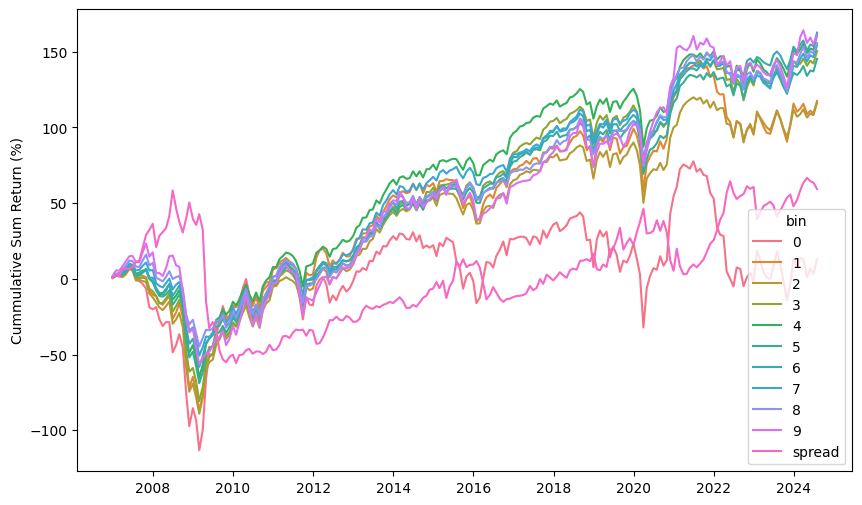

In [644]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

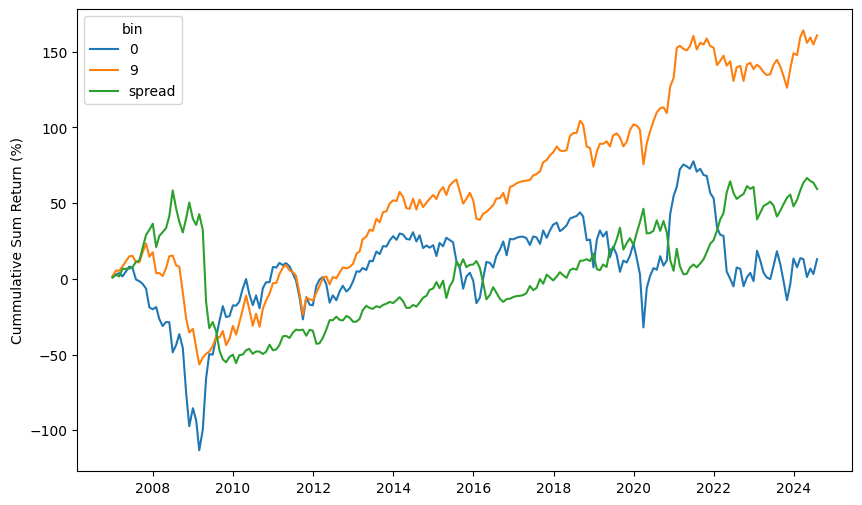

In [645]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin"
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

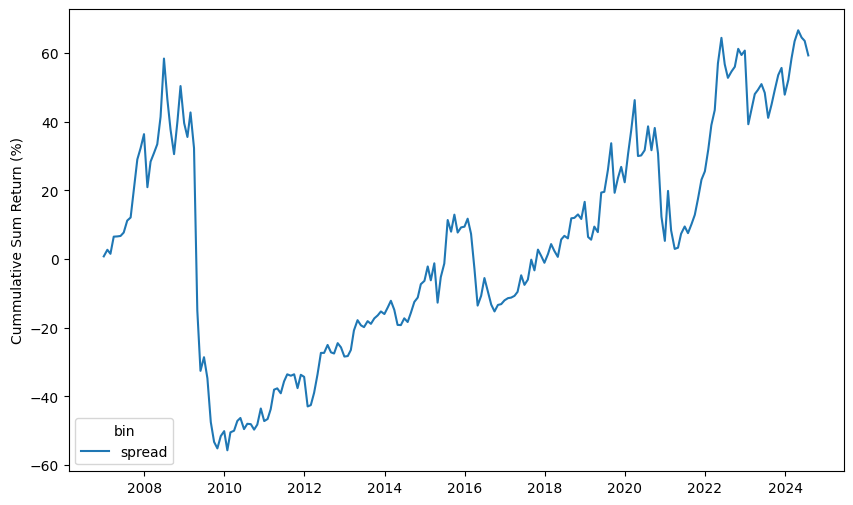

In [646]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [647]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 2006-12-29 to 2024-07-31
